In [1]:
!pip install tensorflow numpy matplotlib pillow


In [2]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [39]:
color_to_class = {
    0: (255, 52, 255, 255),  # Flat areas
    1: (28, 230, 255, 255),  # Areas close to water sources
    2: (255, 74, 70, 255),   # Steep areas
    3: (0, 137, 65, 255),    # Dense vegetation areas
    4: (122, 73, 0, 255),    # Occupied areas
    5: (0, 111, 166, 255),   # Restricted areas
    6: (248, 226, 76, 255),  # Agriculture areas
    # 添加其他类别的映射
}

def color_mask_to_categorical(mask, color_to_class, num_classes):
    mask_array = np.array(mask)
    categorical_mask = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=int)

    for color, class_id in color_to_class.items():
        matches = np.all(mask_array == np.array(color, dtype=np.uint8), axis=-1)
        categorical_mask[matches] = class_id

    return to_categorical(categorical_mask, num_classes=num_classes)

def load_and_preprocess_image(image_path, mask_path, target_size=(256, 256), num_classes=8):
    image = Image.open(image_path).resize(target_size)
    image = np.array(image) / 255.0

    mask = Image.open(mask_path).resize(target_size)
    mask = color_mask_to_categorical(mask, color_to_class, num_classes)

    return image, mask


In [40]:
def image_mask_generator(image_dir, mask_dir, batch_size, target_size=(256, 256), num_classes=8):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')])
    total = len(image_paths)

    while True:
        for start in range(0, total, batch_size):
            x_batch = []
            y_batch = []
            for img_path, mask_path in zip(image_paths[start:start+batch_size], mask_paths[start:start+batch_size]):
                img, mask = load_and_preprocess_image(img_path, mask_path, target_size, num_classes)
                x_batch.append(img)
                y_batch.append(mask)
            yield np.array(x_batch), np.array(y_batch)

In [41]:
def unet_model(input_size=(256, 256, 4), num_classes=8):
    inputs = Input(input_size)
    # Contracting Path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    # Expansive Path
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u4)
    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(u5)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c5)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [42]:
def load_and_preprocess_image(image_path, mask_path, target_size=(256, 256), num_classes=8):
    # 加载并调整图像大小
    image = Image.open(image_path).resize(target_size)
    image = np.array(image) / 255.0  # 归一化图像

    # 加载并调整掩膜大小，掩膜使用最近邻插值
    mask = Image.open(mask_path).resize(target_size, resample=Image.NEAREST)
    mask = np.array(mask)
    mask = mask[:, :, 0]  # 假设掩膜是单通道的，取第一个通道
    mask = mask // 32  # 将0-255范围映射到0-7范围
    mask = to_categorical(mask, num_classes=num_classes)  # 转换为分类格式

    return image, mask

In [43]:
image_dir = '/content/drive/MyDrive/ML/UNET/A'
mask_dir = '/content/drive/MyDrive/ML/UNET/B'

# 创建模型
model = unet_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
train_gen = image_mask_generator(image_dir, mask_dir, batch_size=8)
model.fit(train_gen, steps_per_epoch=(280 // 8), epochs=10)
model.save('path_to_save_model.h5')  # 保存模型

Epoch 1/10
35/35 [==============================] - 77s 2s/step - loss: 1.5880 - accuracy: 0.3753
Epoch 2/10
35/35 [==============================] - 75s 2s/step - loss: 1.2764 - accuracy: 0.3059
Epoch 3/10
35/35 [==============================] - 75s 2s/step - loss: 1.1769 - accuracy: 0.2822
Epoch 4/10
35/35 [==============================] - 76s 2s/step - loss: 1.1334 - accuracy: 0.2754
Epoch 5/10
35/35 [==============================] - 75s 2s/step - loss: 1.1084 - accuracy: 0.2561
Epoch 6/10
35/35 [==============================] - 75s 2s/step - loss: 1.0890 - accuracy: 0.2552
Epoch 7/10
35/35 [==============================] - 75s 2s/step - loss: 1.0856 - accuracy: 0.2569
Epoch 8/10
35/35 [==============================] - 75s 2s/step - loss: 1.0612 - accuracy: 0.2770
Epoch 9/10
35/35 [==============================] - 75s 2s/step - loss: 1.0546 - accuracy: 0.2700
Epoch 10/10
35/35 [==============================] - 76s 2s/step - loss: 1.0454 - accuracy: 0.2777


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 184ms/step


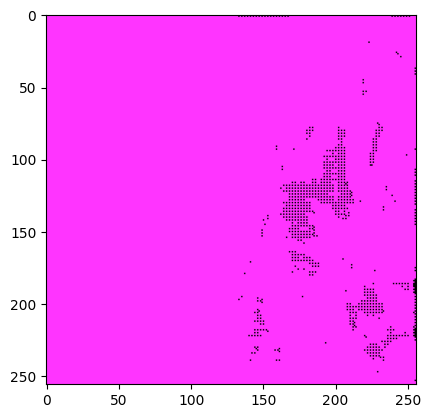

1/1 [==============================] - 0s 74ms/step


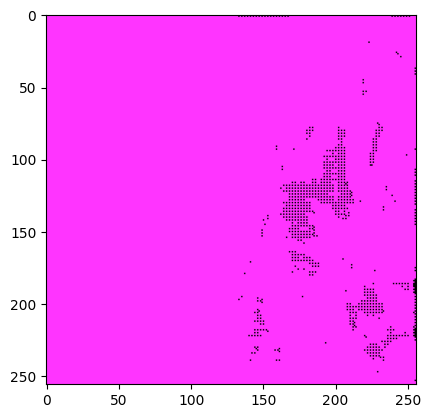

In [45]:
from tensorflow.keras.models import load_model

# 加载模型
model = load_model('path_to_save_model.h5')

# 测试代码
test_image_path = '/content/drive/MyDrive/ML/UNET/testA/4.png'
test_mask_path = '/content/drive/MyDrive/ML/UNET/testB/4.png'

if test_image_path and test_mask_path:
    test_image, test_mask = load_and_preprocess_image(test_image_path, test_mask_path)
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = model.predict(test_image)
    predicted_class_indices = np.argmax(predicted_mask[0], axis=-1)

    color_mask = class_to_color(predicted_class_indices, index_to_color)
    plt.imshow(color_mask)
    plt.show()
else:
    print("没有找到图像，请检查路径！")

# 类别到颜色的映射
index_to_color = {
    0: (255, 52, 255, 255),  # Flat areas
    1: (28, 230, 255, 255),  # Areas close to water sources
    2: (255, 74, 70, 255),   # Steep areas
    3: (0, 137, 65, 255),    # Dense vegetation areas
    4: (122, 73, 0, 255),    # Occupied areas
    5: (0, 111, 166, 255),   # Restricted areas
    6: (248, 226, 76, 255),  # Agriculture areas
    # 添加其他类别的映射
}

def class_to_color(mask, index_to_color):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for idx, color in index_to_color.items():
        indices = (mask == idx)
        color_mask[indices, 0] = color[0]  # R通道
        color_mask[indices, 1] = color[1]  # G通道
        color_mask[indices, 2] = color[2]  # B通道
    return color_mask

# 获取模型的预测结果
predicted_mask = model.predict(test_image)
predicted_class_indices = np.argmax(predicted_mask[0], axis=-1)  # 获取每个像素点的类别索引

# 将类别索引转换为颜色
color_mask = class_to_color(predicted_class_indices, index_to_color)

# 显示彩色掩膜
plt.imshow(color_mask)
plt.show()
